In [82]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [83]:
d = 10
mvn = torch.distributions.MultivariateNormal(torch.tensor([[25.], [-25]]).repeat(1,d) , torch.eye(d).unsqueeze(0).repeat(2,1,1))
weights = torch.distributions.Categorical(torch.tensor([.5,.5]))
distribution = torch.distributions.MixtureSameFamily(weights,mvn)

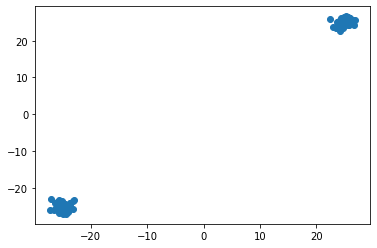

In [84]:
sample = distribution.sample([100])
plt.scatter(sample[:,0].numpy(),sample[:,1].numpy())

In [129]:
import torch
from torch import nn
from torch.distributions import Categorical
from tqdm import tqdm

from models_dif.multivariate_normal_reference import MultivariateNormalReference
from models_dif.location_scale_flow import LocationScaleFlow
from models_dif.softmax_weight import SoftmaxWeight

class DIFSampler(nn.Module):
    def __init__(self, target_log_density, p, K):
        super().__init__()
        self.target_log_density = target_log_density
        self.p = p
        self.K = K

        self.w = SoftmaxWeight(self.K, self.p, [])

        self.T = LocationScaleFlow(self.K, self.p)

        self.reference = MultivariateNormalReference(self.p)

        self.loss_values = []
        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.Adam(self.para_list, lr=5e-2)
    
    def set_target_log_density(self, target_log_density):
        self.target_log_density = target_log_density



    def compute_log_v(self, x):
        z = self.T.forward(x)
        log_v = self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.T.log_det_J(x)
        return log_v - torch.logsumexp(log_v, dim=-1, keepdim=True)

    def DKL_observed(self, z):
        x = self.T.backward(z)
        return torch.mean(torch.sum(torch.exp(self.w.log_prob(z))*(self.model_log_density(x) - self.target_log_density(x)),dim = -1))

    def DKL_latent(self,z):
        return torch.mean(self.reference.log_density(z) - self.proxy_log_density(z))

    def sample_model(self, num_samples):
        with torch.no_grad():
            z = self.reference.sample(num_samples)
            x = self.T.backward(z)
            pick = Categorical(torch.exp(self.w.log_prob(z))).sample()
            return torch.stack([x[i, pick[i], :] for i in range(num_samples)])

    def proxy_log_density(self, z):
        x = self.T.backward(z)
        return torch.logsumexp(torch.diagonal(self.compute_log_v(x), 0, -2, -1) + self.target_log_density(x) - self.T.log_det_J(x), dim=-1)

    def model_log_density(self, x):
        z = self.T.forward(x)
        return torch.logsumexp(torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.reference.log_density(z) + self.T.log_det_J(x),
            dim=-1)

    def train(self, epochs,num_samples, batch_size=None):
        if batch_size is None:
            batch_size = num_samples

        reference_samples = self.reference.sample(num_samples)
        dataset = torch.utils.data.TensorDataset(reference_samples)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        pbar = tqdm(range(epochs))
        for t in pbar:
            for i, batch in enumerate(dataloader):
                self.optimizer.zero_grad()
                batch_loss = self.DKL_observed(batch[0])
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                DKL_observed_values = self.DKL_observed(reference_samples).item()
                #DKL_latent_values = torch.tensor([self.DKL_latent(batch[0].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            #pbar.set_postfix_str('DKL observed = ' + str(round(DKL_observed_values, 6)) + ' DKL Latent = ' + str(round(DKL_latent_values, 6)) + ' ; device: ' + 'cuda' if torch.cuda.is_available() else 'DKL observed = ' + str(round(DKL_observed_values, 6)) + ' DKL Latent = ' + str(round(DKL_latent_values, 6)) + ' ; device: ' + 'cpu')
            pbar.set_postfix_str('DKL observed = ' + str(round(DKL_observed_values, 6)) + ' ; device: ' + 'cuda' if torch.cuda.is_available() else 'DKL observed = ' + str(round(DKL_observed_values, 6)) + ' ; device: ' + 'cpu')
        self.to(torch.device('cpu'))
        

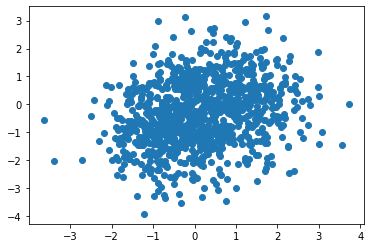

In [116]:
dif = DIFSampler(distribution.log_prob, d,2)
samples = dif.sample_model(1000)
plt.scatter(samples[:,0].numpy(),samples[:,1].numpy())

In [117]:
dif.train(200,50000,5000)
samples = dif.sample_model(1000)
plt.scatter(samples[:,0].numpy(),samples[:,1].numpy())

  8%|████████▍                                                                                                 | 16/200 [00:07<01:21,  2.26it/s, DKL observed = 2751.408203 ; device: cpu]


KeyboardInterrupt: 

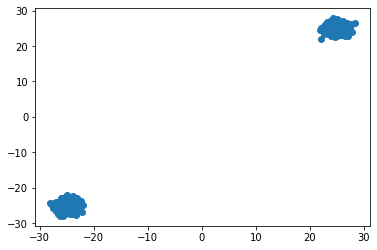

In [131]:
dif = DIFSampler(None, d, 2)
import numpy as np
for ct in np.linspace(25,1,200):
    target_log_density = lambda samples : distribution.log_prob(float(ct)*samples)
    dif.set_target_log_density(target_log_density)
    dif.train(100,5000,500)
    clear_output(wait = True)
    samples = dif.sample_model(1000)
    plt.scatter(samples[:,0].numpy(),samples[:,1].numpy())
    plt.show()